In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [11]:
train_data = pd.read_csv(RAW_PATH / 'train.csv', parse_dates=['date'])
train_data = train_data.set_index('date')

In [12]:
train_data.head()

,nextDayPlayerEngagement,games,rosters,playerBoxScores,teamBoxScores,transactions,standings,awards,events,playerTwitterFollowers,teamTwitterFollowers
date,,,,,,,,,,,
2018-01-01,"[{""engagementMetricsDate"":""2018-01-02"",""player...",NaN,"[{""playerId"":400121,""gameDate"":""2018-01-01"",""t...",NaN,NaN,"[{""transactionId"":340732,""playerId"":547348,""pl...",NaN,NaN,NaN,"[{""date"":""2018-01-01"",""playerId"":545361,""playe...","[{""date"":""2018-01-01"",""teamId"":147,""teamName"":..."
2018-01-02,"[{""engagementMetricsDate"":""2018-01-03"",""player...",NaN,"[{""playerId"":134181,""gameDate"":""2018-01-02"",""t...",NaN,NaN,"[{""transactionId"":339458,""playerId"":621173,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-03,"[{""engagementMetricsDate"":""2018-01-04"",""player...",NaN,"[{""playerId"":425492,""gameDate"":""2018-01-03"",""t...",NaN,NaN,"[{""transactionId"":347527,""playerId"":572389,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-04,"[{""engagementMetricsDate"":""2018-01-05"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-04"",""t...",NaN,NaN,"[{""transactionId"":339549,""playerId"":545343,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-05,"[{""engagementMetricsDate"":""2018-01-06"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-05"",""t...",NaN,NaN,"[{""transactionId"":341195,""playerId"":628336,""pl...",NaN,NaN,NaN,NaN,NaN


### time and player data 

In [13]:
from pipeline import *

In [14]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [15]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [16]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

### target 

In [17]:
from command.ingest_data import *

In [18]:
from data.util import *

In [19]:
%time target = ingest_target(train_data)

preprocessing target
CPU times: user 35.8 s, sys: 616 ms, total: 36.4 s
Wall time: 36.5 s


In [20]:
target.head()

,playerId,target1,target2,target3,target4,date,target_avg
0,112526,0.055277,5.496109,0.025839,16.176471,2018-01-01,5.438424
1,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02,2.971345
2,112526,0.029341,1.648352,0.032613,10.490112,2018-01-03,3.050104
3,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04,5.464896
4,112526,0.083916,1.161002,0.024759,6.643880,2018-01-05,1.978389


In [21]:
df = target.copy()

In [22]:
df = filter_by_id(df, player_in_test)

In [23]:
playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()

In [24]:
playerList

,playerId,target_avg
0,547180,18.775985
1,660271,18.055585
2,545361,17.410036
3,605141,17.236386
4,592450,16.850044
...,...,...
1182,593590,0.119988
1183,656458,0.115664
1184,676424,0.094298
1185,641927,0.086976


In [25]:
df = filter_by_id(df, playerList['playerId'].head(5))

In [26]:
df.playerId.nunique()

5

In [27]:
# player stats

In [28]:
train_data.columns

Index(['nextDayPlayerEngagement', 'games', 'rosters', 'playerBoxScores',
       'teamBoxScores', 'transactions', 'standings', 'awards', 'events',
       'playerTwitterFollowers', 'teamTwitterFollowers'],
      dtype='object')

In [29]:
df = ingest_player_stats(df, train_data)

### preprocessing 

In [30]:
# from pipeline.stats import *
# from pipeline.categories import *
# from pipeline.continuous import *
# from pipeline.core import *

In [31]:
def gen_hardcoded_features(df: pd.DataFrame):
    # some feature eng for the dates
    df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
    df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
    df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
    # normalize
    df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
    
    return df

In [32]:
def fillna(df: pd.DataFrame, fill_value=-1):
    return df.fillna(-1)

In [33]:
# transformer for joining data and create base features

join_season_tmf = FunctionTransformer(join_season_info,
                                      kw_args={'path_to_season': RAW_PATH / 'seasons.csv',
                                             'date_attr': ['year', 'month', 'week']})
join_players_tmf = FunctionTransformer(join_players_info, kw_args={'path_to_players': RAW_PATH / 'players.csv'})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [34]:
# creating pipeline
join_and_compute_feat_pl = Pipeline([('season', join_season_tmf),
                                     ('players', join_players_tmf),
                                     ('hardcoded_feat', harcoded_feat_tmf)])

In [35]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [36]:
# categories encoding
categories = ['playerId', 'seasonPart']
categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [37]:
# target statistics

stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'], windows=[150], drop_index=True)
stats_lagger_tmf = LagGen(lags=[60], drop_index=False)

# create mean and median stats after lagging the target 1 day
stats_lagger_tmf = Pipeline([('lags', stats_lagger_tmf),
                             ('stats', stats_gen_tmf),
                             ('fillnan', FunctionTransformer(fillna)),
                             ('normalize', PdScaleNorm())])

# last 11 days as features
lagger_tmf = Pipeline([('lags', LagGen(lags=[1])),
                       ('fillnan', FunctionTransformer(fillna)),
                       ('normalize', PdScaleNorm())])


target_stats_tmf = PdColumnTransformer([
    ('lags_stats', stats_lagger_tmf, pp_cols),
#                                         ('lags', lagger_tmf, pp_cols)
                                  ])

In [38]:
# continuous preprocessing


# get the rest of the continuous features
continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures()),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())])

In [39]:
# putting all together
all_features_tmf = PdFeatureUnion([('target_stats', target_stats_tmf), 
                                   ('cont_feat', continuous_feat_tmf), 
                                  ('cats', categories_tmf)
                                  ])

In [40]:
# main pipeline with all steps 
pipeline = Pipeline([('join_compute', join_and_compute_feat_pl),
                    ('features_gen', all_features_tmf)])

In [41]:
pipeline

Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7fa4c5875670>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month',
                                                                             'week'],
                                                               'path_to_season': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7fa4c5875550>,
                                                      kw_args={'path_to_players': PosixPath('data/ra...
                                                                                       'date',
                                                                                       'pl

In [42]:
from data.split import *

In [43]:
sp = SplitData("2021-04-01")

In [44]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [45]:
pipeline.fit(sp.filter(df, train_idx))

src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7fa4c5875670>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month',
                                                                             'week'],
                                                               'path_to_season': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7fa4c5875550>,
                                                      kw_args={'path_to_players': PosixPath('data/ra...
                                                                                       'date',
                                                                                       'pl

In [46]:
features = pipeline.transform(df)

src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


In [47]:
pd.options.display.max_rows = 100
features.T

,0,1,2,3,4,5,6,7,8,9,...,6103,6104,6105,6106,6107,6108,6109,6110,6111,6112
target1__60lag__mean__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.085007,0.084823,0.087119,0.097274,0.103969,0.106397,0.107805,0.110583,0.112382,0.115505
target1__60lag__median__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.051362,0.051362,0.051362,0.051362,0.051362,0.051685,0.051761,0.052077,0.052574,0.053132
target1__60lag__std__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.168863,0.168846,0.170379,0.203906,0.215357,0.216321,0.216477,0.217774,0.218133,0.219873
target2__60lag__mean__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.089686,0.090274,0.089725,0.090223,0.092416,0.093632,0.095504,0.096391,0.098498,0.099343
target2__60lag__median__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.062333,0.062333,0.062333,0.062333,0.062333,0.062814,0.063899,0.066172,0.067612,0.067612
target2__60lag__std__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.163653,0.164206,0.163139,0.165394,0.172510,0.173245,0.176042,0.175974,0.179367,0.180368
target3__60lag__mean__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.039042,0.039229,0.040768,0.042822,0.042883,0.043020,0.044499,0.048610,0.049115,0.049762
target3__60lag__median__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.014194,0.014199,0.014202,0.014202,0.014202,0.014202,0.014202,0.014202,0.014213,0.014213
target3__60lag__std__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.144203,0.144166,0.147171,0.155450,0.155490,0.155482,0.158005,0.178558,0.178598,0.178828
target4__60lag__mean__150d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.077117,0.076272,0.076324,0.077195,0.078824,0.079762,0.080670,0.081178,0.081753,0.082088


In [48]:
continuous_feat = features.columns.drop(categories)

In [49]:
df[target_cols] = df[target_cols].astype(np.float32)

In [50]:
train_data = sp.filter(features, train_idx)
raw_train_df = sp.filter(df, train_idx)

In [51]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [52]:
train_data.shape, raw_valid_df.shape

((5962, 96), (151, 89))

In [53]:
valid_data.shape, raw_train_df.shape

((151, 96), (5962, 89))

In [54]:
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [55]:
from torch.utils.data import DataLoader
import torch
from typing import Dict


class PlayerDataset:
    def __init__(self, features: np.ndarray,
                 categories: np.ndarray,
                 target: np.ndarray = None,
                 lag: int = 10,
                 device: torch.device = torch.device('cpu')):
        self.features = features
        self.target = target
        self.lag = lag - 1
        self.device = device
        self.categories = categories
        assert len(self) > self.lag, f'lenght: {len(self)}, lags: {self.lag}'
        
    def __len__(self):
        return len(self.features)
    
    def _to_torch(self, array):
        return torch.from_numpy(np.asarray(array)).to(device=self.device)
    
    def to_device(self, batch_item: Dict[str, np.ndarray]):
        return {name: self._to_torch(values)
                for name, values in batch_item.items()}
    
    def __getitem__(self, idx: int):
        
        start_idx = max(0, idx - self.lag)
        timeft = self.features[start_idx: idx + 1]
        
        if len(timeft) <= self.lag:
            missing_steps = self.lag - len(timeft) + 1
            timeft = np.pad(timeft, pad_width=((missing_steps, 0), (0, 0)))        
        cats = self.categories[idx]
        
        batch_item = {"features": timeft, 'categories': cats}
        if self.target is not None:
            batch_item['target'] = self.target[idx]
    
        return self.to_device(batch_item)

    
class MultiPlayerDataset:
    def __init__(self, ds: List[PlayerDataset]):
        self.ds = ds
        self.cum_lenght = np.cumsum([0] + list(map(len, self.ds)))
        
    def __len__(self):
        return self.cum_lenght[-1]
    
    def __getitem__(self, idx):
        ds_idx = np.argmax(self.cum_lenght > idx) - 1
        ds = self.ds[ds_idx]        
        right_idx = idx - self.cum_lenght[ds_idx]
        return ds[idx - self.cum_lenght[ds_idx]]

    @classmethod
    def from_df(cls, df: pd.DataFrame, features: List[str],
               categories: List[str],
               target: List[str]=None,
               lag: int = 30):
#         df.sort_values(by=['playerId', 'date'], inplace=True)
        df.reset_index(drop=True, inplace=True)
        
        ds = []
        for playerId, pdf in df.groupby('playerId'):
            pl_target = (pdf.loc[:, target].to_numpy() if target is not None else None)
            pds = PlayerDataset(pdf.loc[:, features].to_numpy(),
                                pdf.loc[:, categories].to_numpy(),
                                target=pl_target,
                                lag=lag)
            ds.append(pds)
        
        return cls(ds)

In [56]:
from deepmed.learner import Learner
from deepmed.callback import CallBack

In [57]:
from deepmed.callback.checkpoint import ModelCheckpointCallBack
from deepmed.callback.record import Recorder, MetricRecorderCallBack
from deepmed.callback.progress_bar import ProgressBarCallBack
from deepmed import layers as ll
from deepmed.data import DataBunch, predict_dl
# from deepned.callback.schedule import 

In [58]:
from torch import nn, optim
from torch.nn import functional as F

In [59]:
def mae(yhat, y):
    return torch.abs(yhat-y).mean()

In [60]:
class BatchNorm1d(nn.BatchNorm1d):
    def forward(self, x):
        swapx = x.transpose(1, 2).contiguous()
        swapx = super().forward(swapx)
        return swapx.transpose(1, 2).contiguous()

In [61]:
from typing import List, Tuple


class EmbeddingLayer(nn.Module):
    def __init__(self, emb_szs: List[Tuple[int, int]], dropout: float = 0.):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.emb = nn.ModuleList([nn.Embedding(size, hidden_dim)
                              for (size, hidden_dim) in emb_szs])
        
        self.out_features = sum([hidden_dim for (_, hidden_dim) in emb_szs])
    
    def forward(self, x):
        output = torch.cat([emb(x[:, e]) for e, emb in enumerate(self.emb)], dim=1)
        output = self.dropout(output)
        return output

In [62]:
class LstmModel(nn.Module):
    def __init__(self, in_features: int,
                 emb_szs,
                 hidden_dim: int,
                 out_features: int = 1,
                n_layers: int = 2):
        super().__init__()
        self.emb = EmbeddingLayer(emb_szs, dropout=0.05)
        self.hidden_dim = hidden_dim
        self.net = nn.LSTM(in_features, hidden_dim, batch_first=True)
        # decoder
        self.output_layer = nn.Sequential(nn.Linear(hidden_dim + self.emb.out_features, hidden_dim),
                                          nn.ReLU(),
                                          nn.BatchNorm1d(hidden_dim),
                                          nn.Dropout(0.05),
                                          nn.Linear(hidden_dim, out_features))
        self.loss = mae#F.mse_loss
#         self.bn = BatchNorm1d(in_features)
        
    def _init_hidden(self, bs):
        return next(self.parameters()).new(1, bs, self.hidden_dim).zero_()
        
    def init_hidden_state(self, bs):
        return (self._init_hidden(bs), self._init_hidden(bs))
    
    def forward(self, features,
                categories,
                target=None):
        
        bs, sq, ft = features.size()
#         features = self.bn(features)
        hidden_state = self.init_hidden_state(bs)
        
        _, (final_state, _) = self.net(features, hidden_state)
        
        final_state.squeeze_(dim=0)
        
        categories = self.emb(categories)
        
        final_state = torch.cat((categories, final_state), dim=1)
        
#         print(final_state.shape)
        prediction = self.output_layer(final_state)
        # scaled prediction to 0 to 100
        prediction = torch.sigmoid(prediction) * 100
        
        output = {'prediction': prediction}
        
        if target is not None:
            loss = self.loss(prediction, target)
            output['loss'] = loss
            
        return output

In [63]:
torch.manual_seed(2021)

In [64]:
LAGS = 7
batch_size = 512

In [65]:
train_ds = MultiPlayerDataset.from_df(train_data, continuous_feat, categories, target_cols, lag=LAGS)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [66]:
valid_ds = MultiPlayerDataset.from_df(valid_data, continuous_feat, categories, target_cols, lag=LAGS)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [67]:
get_szs_size = lambda size: (size+1, min(size//2, 50))

In [68]:
emb_szs = [get_szs_size(size) for size in train_data.loc[:, categories].nunique()]

In [69]:
emb_szs

[(6, 2), (8, 3)]

In [70]:
model = LstmModel(len(continuous_feat), emb_szs=emb_szs, hidden_dim=50, out_features=len(target_cols))

In [71]:
model

LstmModel(
  (emb): EmbeddingLayer(
    (dropout): Dropout(p=0.05, inplace=False)
    (emb): ModuleList(
      (0): Embedding(6, 2)
      (1): Embedding(8, 3)
    )
  )
  (net): LSTM(94, 50, batch_first=True)
  (output_layer): Sequential(
    (0): Linear(in_features=55, out_features=50, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=50, out_features=4, bias=True)
  )
)

In [72]:
# model.bn.weight.data


In [73]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [74]:
bunch = DataBunch(train_dl, valid_dl)

In [75]:
# batch = next(iter(train_dl))

In [76]:
learner = Learner(model, optimizer, bunch, callbacks=[ProgressBarCallBack(),
                                                      MetricRecorderCallBack()])

In [77]:
learner.fit(10)

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/12 [00:00<?, ?it/s]

epoch=0 train: loss=30.15574, valid: loss=26.02411
epoch=1 train: loss=17.18629, valid: loss=21.18969
epoch=2 train: loss=13.66984, valid: loss=18.16167
epoch=3 train: loss=13.05817, valid: loss=16.82209
epoch=4 train: loss=12.69109, valid: loss=16.18726
epoch=5 train: loss=12.45574, valid: loss=17.89112
epoch=6 train: loss=12.20918, valid: loss=15.09830
epoch=7 train: loss=12.08504, valid: loss=15.64470
epoch=8 train: loss=11.94433, valid: loss=15.13260
epoch=9 train: loss=11.85439, valid: loss=15.66667


In [78]:
valid_output = predict_dl(model, valid_dl)

In [79]:
valid_prediction = pd.DataFrame(valid_output['prediction'].numpy(), columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

In [80]:
valid_prediction[pp_cols] = raw_valid_df[pp_cols]

In [81]:
def predict_fn(raw_df: pd.DataFrame):
    test_features = pipeline.transform(raw_df)
#     return test_features
    test_ds = MultiPlayerDataset.from_df(test_features, features=continuous_feat,
                                         categories=categories, lag=LAGS)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    output = predict_dl(model, test_dl)
    
    
    return output['prediction'].numpy()

In [82]:
from typing import Dict, Callable

def predict_recursive(test_df: pd.DataFrame,
                      raw_df: pd.DataFrame, 
                      predict_fn: Callable,
                      n_days: int=0):
        
    assert test_df['date'].nunique() == 1, \
           'the test set has more than one date'

    test_date = test_df['date'].iloc[0]
    last_date = raw_df['date'].max()
    
    assert test_date - last_date == pd.to_timedelta(1, unit='d'), \
           f'the test date ({test_date}) must be one day after the last_date ({last_date})'
    # append information
    raw_df = raw_df.append(test_df, ignore_index=True)
    # sort by index and dates
    raw_df.sort_values(by=['playerId', 'date'], inplace=True)
    raw_df.reset_index(drop=True, inplace=True)
    # get the index to locate the test df
    index = (raw_df['date'] == test_date)
    
    assert index.sum() == len(test_df)
    # predict
    prediction = predict_fn(raw_df)
#     return prediction.loc[index], raw_df
    # filter prediction
    prediction = prediction[index]
    # create a dataframe with the prediction
    prediction_df = pd.DataFrame(prediction, columns=target_cols)
    prediction_df['date'] = test_date
    prediction_df['playerId'] = raw_df.loc[index, 'playerId'].to_numpy()
    print(prediction_df.head())
    # add the prediction to the dataset
    raw_df.loc[index, target_cols] = prediction
    return prediction_df, raw_df

In [83]:
raw_train_fr = raw_train_df.query("date >= '2020-07-01'").reset_index(drop=True)
raw_train_fr = raw_train_fr[df.columns]

recursive_prediction = []
for date, val_date_df in raw_valid_df.groupby('date'):
    val_date_df = val_date_df[df.columns].reset_index(drop=True)
    _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
                                                     raw_train_fr,
                                                     predict_fn)
    recursive_prediction.append(_recurive_pred)

recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
recursive_prediction.reset_index(drop=True, inplace=True)
recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
                                     for f in target_cols}, inplace=True)
recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  4.715351  27.484051  2.985568  20.780937 2021-04-01    545361
1  2.242140  21.117935  1.573489  14.095084 2021-04-01    547180
2  3.441633  17.251345  1.356659  12.811835 2021-04-01    592450
3  2.371009  12.240382  0.983888   4.860428 2021-04-01    605141
4  1.530643  13.235577  0.775132   6.365395 2021-04-01    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  5.653001  30.135132  3.074292  19.368160 2021-04-02    545361
1  1.233040  19.268568  1.590795  16.754351 2021-04-02    547180
2  1.845841  15.460155  1.323089  14.562358 2021-04-02    592450
3  1.787328  12.020701  0.736651   4.249625 2021-04-02    605141
4  7.935931  22.151806  2.714884   8.837789 2021-04-02    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  1.908623  24.424946  1.281660  15.787561 2021-04-03    545361
1  2.009292  21.522655  1.344511  13.306980 2021-04-03    547180
2  5.257091  20.344299  2.013811  14.736876 2021-04-03    592450
3  0.763248   9.934514  0.575368   4.920529 2021-04-03    605141
4  1.419015  15.050448  0.695733   6.346357 2021-04-03    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2    target3    target4       date  playerId
0  2.175738  24.724117   1.337835  15.154128 2021-04-04    545361
1  1.812665  21.298079   1.125714  12.081978 2021-04-04    547180
2  2.397525  17.521259   1.038265  12.505661 2021-04-04    592450
3  1.241779  10.936436   0.569178   4.006527 2021-04-04    605141
4  5.509130  47.221390  57.131260  20.084261 2021-04-04    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2   target3    target4       date  playerId
0   9.958556  34.546635  4.547386  20.075815 2021-04-05    545361
1   2.127958  22.099716  1.224295  12.145759 2021-04-05    547180
2  18.923178  29.045673  5.781079  18.744846 2021-04-05    592450
3   0.901496  10.147131  0.407276   3.451243 2021-04-05    605141
4   0.739447  23.835384  0.887881   9.051122 2021-04-05    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2    target3    target4       date  playerId
0  10.260141  37.273327   4.857145  21.178011 2021-04-06    545361
1   1.182891  19.723831   0.750917  10.599993 2021-04-06    547180
2  42.018566  39.998161  14.055188  24.600832 2021-04-06    592450
3   3.179190  14.309502   1.087865   4.438783 2021-04-06    605141
4   1.793565  21.185743   1.178938   7.964856 2021-04-06    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  2.250060  28.880491  2.607758  23.799198 2021-04-07    545361
1  3.455832  25.021257  1.711035  12.840706 2021-04-07    547180
2  4.358175  24.178909  3.298180  20.549721 2021-04-07    592450
3  0.761046  10.651883  0.570996   4.972145 2021-04-07    605141
4  0.971734  18.189426  1.251112   9.519739 2021-04-07    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2    target3    target4       date  playerId
0  24.513123  44.622498  11.746832  27.947123 2021-04-08    545361
1   1.327544  20.355433   1.358283  14.779702 2021-04-08    547180
2   3.291815  20.249828   2.681441  19.215879 2021-04-08    592450
3   0.826861  10.113612   0.653187   5.440283 2021-04-08    605141
4   2.312839  19.969816   1.316952   8.155954 2021-04-08    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2   target3    target4       date  playerId
0   4.576633  33.081821  2.764329  19.529299 2021-04-09    545361
1   1.679093  20.619347  1.103448  12.258747 2021-04-09    547180
2   2.338546  17.681278  2.005389  17.788416 2021-04-09    592450
3   0.838841   9.521220  0.672005   5.529788 2021-04-09    605141
4  18.227135  33.284462  6.557107  12.134581 2021-04-09    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  1.907083  26.348797  1.366386  16.062105 2021-04-10    545361
1  9.690733  31.628681  4.263721  16.584393 2021-04-10    547180
2  5.573092  21.826662  2.391073  16.466623 2021-04-10    592450
3  0.912049   9.698992  0.734879   6.013716 2021-04-10    605141
4  2.599029  23.080048  1.410359   8.790125 2021-04-10    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  1.842931  25.724247  2.266075  21.779442 2021-04-11    545361
1  8.614433  33.023685  4.017622  17.048512 2021-04-11    547180
2  4.252169  21.367224  1.860745  15.468395 2021-04-11    592450
3  0.972543   9.847540  0.808191   6.420467 2021-04-11    605141
4  1.199634  15.430671  1.057944   8.293788 2021-04-11    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2   target3    target4       date  playerId
0  12.039911  36.077778  6.048066  22.359547 2021-04-12    545361
1   1.923270  24.738581  2.124777  18.087658 2021-04-12    547180
2   3.182018  19.003077  1.399559  13.845656 2021-04-12    592450
3   1.023002   9.998180  0.886036   6.731086 2021-04-12    605141
4   9.863806  24.961851  3.379838   9.620549 2021-04-12    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  2.067044  24.631065  1.352718  14.655268 2021-04-13    545361
1  1.794318  23.222099  1.275576  13.580483 2021-04-13    547180
2  1.665067  21.746004  1.074246  12.016391 2021-04-13    547180
3  2.486364  17.649857  1.081786  12.601562 2021-04-13    592450
4  5.892648  16.761404  2.205704   6.493229 2021-04-13    605141


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2    target3    target4       date  playerId
0   2.809926  26.334900   1.635615  15.220544 2021-04-14    545361
1   1.261918  20.484245   0.845809  11.301107 2021-04-14    547180
2  59.187008  42.806961  21.311905  26.370224 2021-04-14    592450
3   1.390096  12.338661   0.645141   4.484292 2021-04-14    605141
4   1.397504  16.471903   0.737328   6.782015 2021-04-14    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  1.739038  24.439081  1.995204  20.555815 2021-04-15    545361
1  1.276249  20.530426  1.427553  15.577666 2021-04-15    547180
2  4.413260  23.885233  3.282878  20.198261 2021-04-15    592450
3  0.573880   9.679607  0.319258   3.598330 2021-04-15    605141
4  1.185162  15.647096  1.075335   8.423543 2021-04-15    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  6.123848  30.795769  3.434012  19.865379 2021-04-16    545361
1  3.767114  25.135860  2.072767  14.266811 2021-04-16    547180
2  4.391526  21.849863  1.944932  15.876410 2021-04-16    592450
3  0.916932  10.420503  0.412672   3.527834 2021-04-16    605141
4  2.023523  16.299963  0.962662   7.050742 2021-04-16    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  1.874828  24.757374  2.326049  21.439529 2021-04-17    545361
1  1.337463  19.962273  1.493603  15.535540 2021-04-17    547180
2  5.667014  23.378208  2.299046  16.139807 2021-04-17    592450
3  0.714461   9.918259  0.343186   3.295671 2021-04-17    605141
4  1.086130  14.263288  0.963096   7.881932 2021-04-17    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2   target3    target4       date  playerId
0   1.844353  24.822397  2.723130  24.837072 2021-04-18    545361
1  15.616640  35.015831  7.001553  19.620361 2021-04-18    547180
2   3.122496  20.609785  1.466631  14.828327 2021-04-18    592450
3   0.502739   9.052885  0.260942   3.035205 2021-04-18    605141
4   0.979886  13.082190  0.942660   8.017948 2021-04-18    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  2.129756  24.391924  1.652234  17.992702 2021-04-19    545361
1  3.603561  27.601702  2.113688  14.934307 2021-04-19    547180
2  2.855283  20.140215  2.222836  18.126204 2021-04-19    592450
3  1.040815  10.769093  0.456471   3.504841 2021-04-19    605141
4  1.405327  14.199262  0.722192   6.469733 2021-04-19    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2    target3    target4       date  playerId
0  17.887701  39.550117   8.419753  24.053312 2021-04-20    545361
1   3.588457  27.336069   2.035696  14.611819 2021-04-20    547180
2   5.005068  21.667923   2.112950  15.883231 2021-04-20    592450
3   0.586814   9.542286   0.445690   4.390373 2021-04-20    605141
4   5.236247  53.979008  51.043381  30.063778 2021-04-20    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2   target3    target4       date  playerId
0   9.714266  36.118584  4.787752  19.942406 2021-04-21    545361
1  12.390619  35.842060  5.446983  18.290993 2021-04-21    547180
2   4.084127  20.172960  1.679215  14.384192 2021-04-21    592450
3   0.717318   9.514482  0.567605   5.057005 2021-04-21    605141
4   6.643388  39.117546  5.235400  15.327261 2021-04-21    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  1.838928  25.195190  1.288503  14.761087 2021-04-22    545361
1  1.932490  25.832531  2.237429  18.729795 2021-04-22    547180
2  3.624505  19.415020  1.499062  13.812685 2021-04-22    592450
3  0.864594   9.905581  0.427296   3.864887 2021-04-22    605141
4  1.289948  22.068659  0.977149   8.182618 2021-04-22    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  1.554150  23.009687  1.856342  18.882183 2021-04-23    545361
1  1.798837  22.809547  1.201607  12.878304 2021-04-23    547180
2  2.991888  18.938631  1.316697  13.599194 2021-04-23    592450
3  1.014237  10.371019  0.446437   3.715901 2021-04-23    605141
4  2.380697  21.930719  1.316026   8.041492 2021-04-23    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  1.605460  23.081627  2.295330  22.107233 2021-04-24    545361
1  2.201383  23.735060  1.340860  12.763579 2021-04-24    547180
2  4.092558  20.327705  1.687720  14.307756 2021-04-24    592450
3  1.142854  11.393846  0.509671   3.927347 2021-04-24    605141
4  1.100811  18.598389  1.311623   9.553228 2021-04-24    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2    target3    target4       date  playerId
0   1.607254  23.449022   2.556685  24.654058 2021-04-25    545361
1  32.537399  43.952370  12.927176  22.362118 2021-04-25    547180
2   3.128990  19.198431   1.318370  13.292919 2021-04-25    592450
3   0.735164  10.427508   0.339807   3.435951 2021-04-25    605141
4   7.021684  25.459990   2.920383   9.814206 2021-04-25    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2    target3    target4       date  playerId
0   9.388677  33.215611   5.316422  21.811716 2021-04-26    545361
1   1.550163  24.795351   1.071121  12.740848 2021-04-26    547180
2   4.323719  20.965736   1.683582  13.991249 2021-04-26    592450
3   0.653547   9.821655   0.309378   3.271362 2021-04-26    605141
4  99.128014  73.391998  99.991241  63.428200 2021-04-26    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2   target3    target4       date  playerId
0   2.946225  26.756924  1.873940  16.116581 2021-04-27    545361
1   2.314073  24.702595  1.375549  12.809526 2021-04-27    547180
2  17.809502  30.095613  5.746536  19.161478 2021-04-27    592450
3   0.498648   9.174806  0.252620   3.112520 2021-04-27    605141
4   0.987811  27.568554  1.152918  10.084826 2021-04-27    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  2.019985  23.349909  1.289547  13.616705 2021-04-28    545361
1  1.161229  20.107832  0.764778  10.641296 2021-04-28    547180
2  3.490788  21.551922  2.565932  18.484102 2021-04-28    592450
3  1.438917  12.292096  0.586233   3.983922 2021-04-28    605141
4  1.603093  21.355333  1.125729   8.011456 2021-04-28    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


    target1    target2   target3    target4       date  playerId
0  1.339086  21.039278  1.597247  17.149906 2021-04-29    545361
1  1.217479  20.359999  1.321773  14.981503 2021-04-29    547180
2  3.735592  19.704084  1.670844  14.778590 2021-04-29    592450
3  0.726138  10.561502  0.349660   3.507056 2021-04-29    605141
4  1.159620  19.519403  1.483365  10.200691 2021-04-29    660271


src/pipeline.py:192: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


     target1    target2    target3    target4       date  playerId
0   4.039007  25.898361   2.350764  15.893208 2021-04-30    545361
1   1.174094  19.909115   1.588420  17.091106 2021-04-30    547180
2  71.871826  48.965881  31.010523  30.452675 2021-04-30    592450
3   0.600447   9.734876   0.455957   4.577777 2021-04-30    605141
4   7.669470  26.796419   3.342408  10.476267 2021-04-30    660271


In [84]:
from evaluate.metrics import *

with best 500 ids 
one day lag

{'mae_mean': 15.404842,
 'mae_1': 15.112363,
 'mae_2': 12.518346,
 'mae_3': 15.941521,
 'mae_4': 18.04714}
 
{'mae_mean': 16.107979,
 'mae_1': 14.4299965,
 'mae_2': 13.712786,
 'mae_3': 17.216927,
 'mae_4': 19.072205}
 
lag 60 day 150 stats mean median std
raw_valid_df

{'mae_mean': 16.526415,
 'mae_1': 15.134252,
 'mae_2': 15.736391,
 'mae_3': 16.731949,
 'mae_4': 18.503065}
 
{'mae_mean': 16.243195,
 'mae_1': 14.64544,
 'mae_2': 15.223519,
 'mae_3': 16.67205,
 'mae_4': 18.43177}
 
 
with best 500 ids 
one day lag 
{'mae_mean': 2.4375365,
 'mae_1': 2.2795138,
 'mae_2': 3.1164076,
 'mae_3': 1.6708878,
 'mae_4': 2.6833365}
 
{'mae_mean': 3.2938020082107333,
 'mae_1': 2.5740078375938165,
 'mae_2': 5.631358953836824,
 'mae_3': 1.837284798457624,
 'mae_4': 3.1325564429546677}
 
lag 60 day 150 stats mean median std

{'mae_mean': 2.8213322,
 'mae_1': 2.4738746,
 'mae_2': 3.9536836,
 'mae_3': 1.8413752,
 'mae_4': 3.0163958}
 
{'mae_mean': 2.8054446768310446,
 'mae_1': 2.4669433853402922,
 'mae_2': 3.901420425393473,
 'mae_3': 1.8396196560640896,
 'mae_4': 3.0137952405263246}
 
 con toda la data
 
 {'mae_mean': 1.5619345,
 'mae_1': 1.2107118,
 'mae_2': 2.4501314,
 'mae_3': 0.95569867,
 'mae_4': 1.6311963}
 
 
 {'mae_mean': 1.5390999144452775,
 'mae_1': 1.210369386168515,
 'mae_2': 2.3818660584590656,
 'mae_3': 0.9496059085908733,
 'mae_4': 1.6145583045626561}
 

check equal

{'mae_mean': 16.526415,
 'mae_1': 15.134252,
 'mae_2': 15.736391,
 'mae_3': 16.731949,
 'mae_4': 18.503065}

{'mae_mean': 16.356407935829797,
 'mae_1': 15.017943742728194,
 'mae_2': 14.933671032356111,
 'mae_3': 16.786116652388053,
 'mae_4': 18.68790031584683}

In [85]:
compute_metrics(valid_prediction)

{'mae_mean': 15.666671,
 'mae_1': 15.259022,
 'mae_2': 13.671754,
 'mae_3': 15.008789,
 'mae_4': 18.72712}

In [86]:
compute_metrics(recursive_prediction)

{'mae_mean': 15.77636269177156,
 'mae_1': 15.447754194478918,
 'mae_2': 13.700959455098538,
 'mae_3': 15.310129876415067,
 'mae_4': 18.64660724109372}

In [87]:
compute_metrics(valid_prediction.query("date >= '2021-04-07'"))

{'mae_mean': 16.043373,
 'mae_1': 15.884845,
 'mae_2': 14.047419,
 'mae_3': 15.726749,
 'mae_4': 18.514477}

In [88]:
compute_metrics(recursive_prediction.query("date >= '2021-04-07'"))

{'mae_mean': 16.043372137610575,
 'mae_1': 15.884843431721048,
 'mae_2': 14.047418306681735,
 'mae_3': 15.72674829408157,
 'mae_4': 18.514478517957954}

In [89]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

In [90]:
(recursive_prediction.groupby('playerId')
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,25.239232,20.717306,26.720496,24.666090,28.853037
545361,18.482901,15.312065,18.610349,17.635995,22.373197
547180,12.430104,13.717785,10.640965,12.430329,12.931337
605141,12.364480,11.868639,4.635160,13.190068,19.764054
592450,10.476638,15.680642,7.999827,8.724161,9.501920


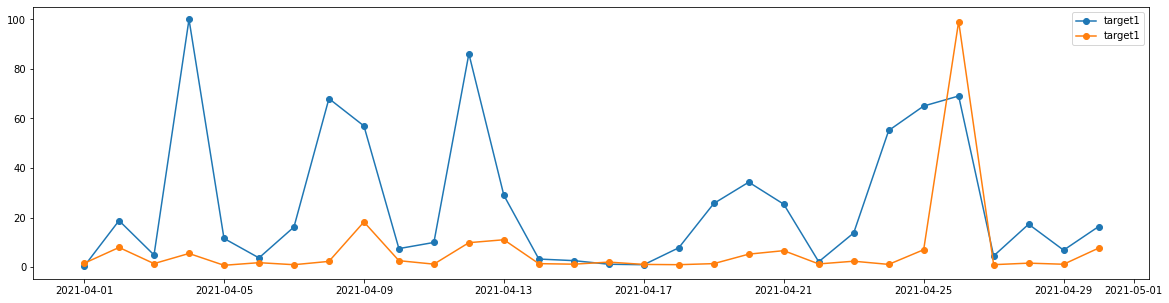

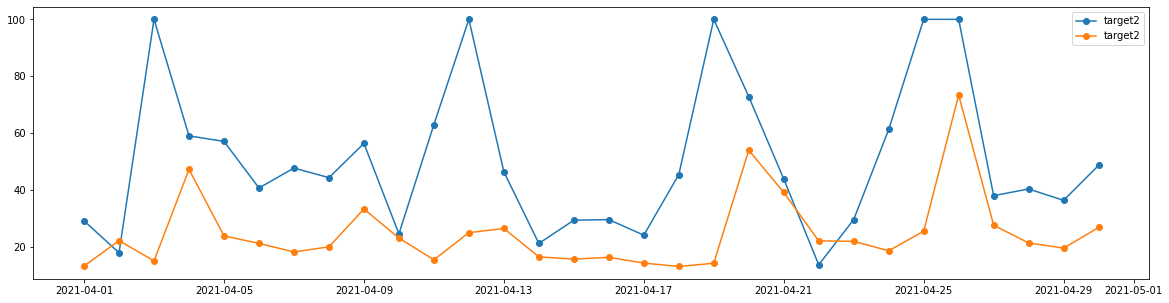

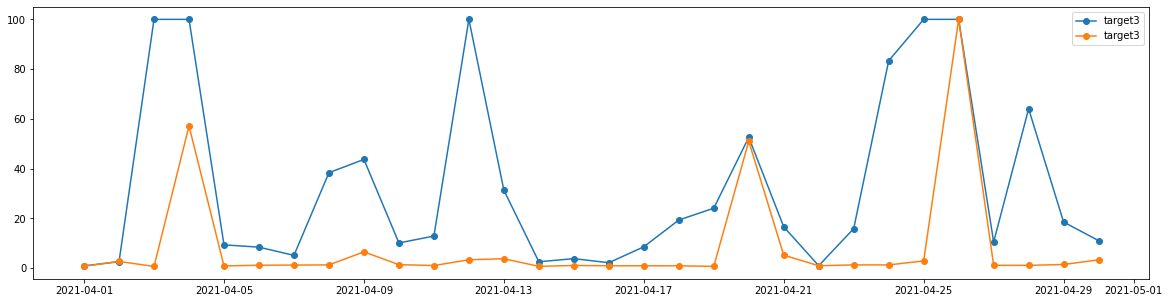

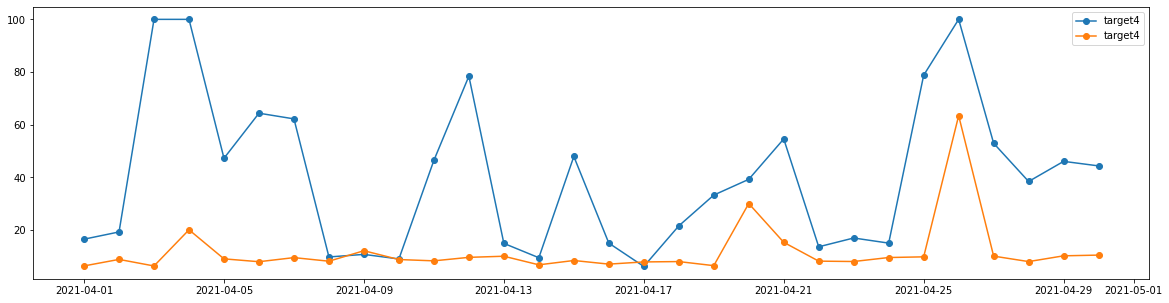

In [91]:
for index in range(1, 5):
    plot_pred(recursive_prediction, playerId=660271, index=index)